In [1]:
import os
from os.path import join as osj
import sys
sys.path.insert(0, osj(os.getcwd(), "scripts"))

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
from lorenz63 import L63
from eakf import eakf_solver
from helper import *
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from gymnasium import spaces, Env
import gymnasium as gym
from stable_baselines3.common.callbacks import EvalCallback

device = torch.device("cpu")

# Step 1: generate underlying model

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


Text(0.5, 0.92, '3D Path Over Time')

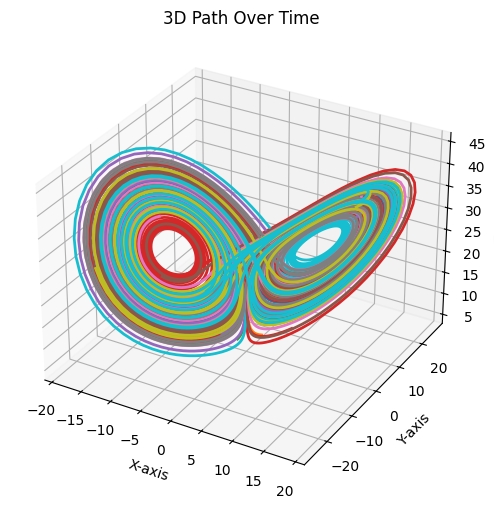

In [2]:
base_initial_condition = [10,20,30]
num_initial_conditions = 20
initial_conditions = generate_close_initial_conditions(base_initial_condition, num_initial_conditions)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for initial_condition in tqdm(initial_conditions):
    sigma, rho, beta = 10, 28, 8/3
    dt = 1e-2
    model = L63(sigma, rho, beta, dt)
    model.initialize([initial_condition[0],initial_condition[1],initial_condition[2]])
    for _ in range(1000):
        model.step()
    data = np.array(model.states)
    ax.plot(data[:,0], data[:,1], data[:,2], linewidth=2)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Path Over Time')


# Step 2: EnKF

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


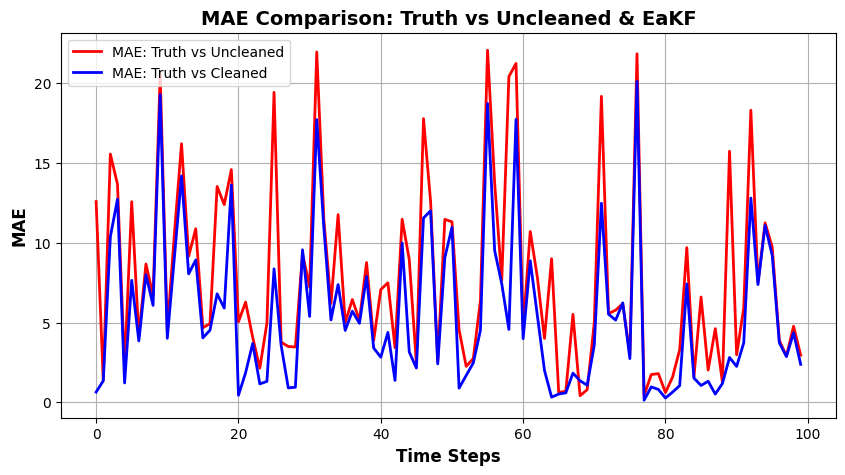

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

'''
This class implements the Lorenz 63 model.
'''
class L63:
    def __init__(self, sigma, rho, beta, dt, use_solve_ivp=False):
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
        self.dt = dt
        self.initialized = False
        self.states = []
        self.times = []
        self.use_solve_ivp = use_solve_ivp

    def initialize(self, values):
        self.reset()
        self.states.append(np.array(values))
        self.times.append(0.0)
        self.initialized = True

    def reset(self):
        self.initialized = False
        self.states = []
        self.times = []

    def derivatives(self, t, state):
        x, y, z = state
        dxdt = self.sigma * (y - x)
        dydt = x * (self.rho - z) - y
        dzdt = x * y - self.beta * z
        return [dxdt, dydt, dzdt]

    def step(self, step_size=1e-2):
        if self.initialized and self.use_solve_ivp:
            sol = solve_ivp(self.derivatives, [0, self.dt], self.states[-1], method='RK45')
            self.states.append(sol.y[:, -1])
            self.times.append(self.times[-1] + self.dt)
            return sol.y[:, -1], self.times[-1] + self.dt
        elif self.initialized:
            derivatives = self.derivatives(0, self.states[-1])
            new_states = self.states[-1]+np.array(derivatives)*self.dt
            self.states.append(new_states)
            self.times.append(self.times[-1] + self.dt)

class CustomEAKFSolver:
    def __init__(self, params, initial_conditions, num_ensembles, model_class):
        self.sigma, self.rho, self.beta = params
        self.num_ensembles = num_ensembles
        self.model_class = model_class
        self.alpha = 1.1  # Covariance inflation factor
        self.innovations = []  # Store innovations for R calibration
        self.initial_conditions = initial_conditions

    def run_eakf(self, H, R, dtda, num_assimilations):
        # Initialize ensemble around initial_conditions (as float)
        ensemble = np.tile(self.initial_conditions, (self.num_ensembles, 1)).astype(float)
        ensemble += np.random.normal(0, 0.5, ensemble.shape)  # Small perturbations

        truth = np.copy(self.initial_conditions)  # Initialize truth
        truth_states = []
        cleaned_states = []
        uncleaned_states = []

        for _ in tqdm(range(num_assimilations)):
            # --- Forecast step with inflation ---
            forecast_ensemble = []
            for x in ensemble:
                model = self.model_class(self.sigma, self.rho, self.beta, dtda)
                model.initialize(x)
                # Propagate model for dtda seconds with dt=1e-2
                # for _ in range(int(dtda / 1e-2)):
                model.step()
                # Use the last state stored in the model
                forecast_ensemble.append(model.states[-1])
            forecast_ensemble = np.array(forecast_ensemble)
            inflated_ensemble = self._inflate_ensemble(forecast_ensemble)

            # --- Propagate truth ---
            truth_model = self.model_class(self.sigma, self.rho, self.beta, dtda)
            truth_model.initialize(truth)
            # for _ in range(int(dtda / 1e-2)):
            truth_model.step()
            truth = truth_model.states[-1]
            truth_states.append(truth)

            # Generate observation
            y_obs = H @ truth + np.random.multivariate_normal(np.zeros(3), R)

            # --- Analysis step ---
            Hx_f = H @ np.mean(inflated_ensemble, axis=0)
            self.innovations.append(y_obs - Hx_f)
            analysis_ensemble = self._analysis_update(inflated_ensemble, H, R, y_obs)

            # Store results
            cleaned_states.append(np.mean(analysis_ensemble, axis=0))
            uncleaned_states.append(np.mean(inflated_ensemble, axis=0))
            ensemble = analysis_ensemble

        # Calibrate R using innovations
        D = np.array(self.innovations)
        sample_cov = np.cov(D.T)
        H_Pf_H = H @ np.cov(inflated_ensemble.T) @ H.T
        R_opt = np.maximum(sample_cov - H_Pf_H, 0.1 * np.eye(3))
        R = R_opt

        return {
            'true_states': np.array(truth_states),
            'cleaned_states': np.array(cleaned_states),
            'uncleaned_states': np.array(uncleaned_states)
        }

    def _inflate_ensemble(self, ensemble):
        """Multiplicative covariance inflation."""
        mean = np.mean(ensemble, axis=0)
        return mean + np.sqrt(self.alpha) * (ensemble - mean)

    def _analysis_update(self, ensemble, H, R, y_obs):
        """Ensemble Adjustment Kalman Filter update."""
        P = np.cov(ensemble.T)
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        # Reshape y_obs to (3,1) so that the subtraction works properly.
        return ensemble + ((y_obs.reshape(-1,1) - (H @ ensemble.T)).T @ K.T)

# ----------------- Setup Parameters -----------------
H = np.eye(3)
R = np.eye(3)
dtda = 1.0  # time between analyses
params = [10, 28, 8/3]
num_ensembles = 20
num_assimilations = 100
initial_conditions = [10, 20, 30]

# Initialize the custom solver with the L63 model
solver = CustomEAKFSolver(params, initial_conditions, num_ensembles, L63)

# Run the solver
sol = solver.run_eakf(H, R, dtda, num_assimilations)

# Compute MAE between the true states and the ensemble means for uncleaned and cleaned states.
mae_uncleaned = np.mean(np.abs(sol['true_states'] - sol['uncleaned_states']), axis=1)
mae_cleaned = np.mean(np.abs(sol['true_states'] - sol['cleaned_states']), axis=1)

# ----------------- Plot the Results -----------------
plt.figure(figsize=(10, 5))
plt.plot(mae_uncleaned, label="MAE: Truth vs Uncleaned", linewidth=2, color='red')
plt.plot(mae_cleaned, label="MAE: Truth vs Cleaned", linewidth=2, color='blue')
plt.xlabel("Time Steps", fontsize=12, fontweight='bold')
plt.ylabel("MAE", fontsize=12, fontweight='bold')
plt.title("MAE Comparison: Truth vs Uncleaned & EaKF", fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.show()


# Step 3: Generate Sample Paths

In [ ]:
# H = np.eye(3)
# R = np.eye(3)
# dtda = 1.0 # time between analyses
# params = [10,28,8/3]
# num_ensembles = 20
# num_assimilations = 1000
# initial_conditions = np.random.randn(3)*100
# solver = eakf_solver(params, initial_conditions, num_ensembles, L63)
# sol = solver.run_eakf(H, R, dtda, num_assimilations)
# np.save(osj(os.getcwd(), "data", "example.npy"), sol)

100%|██████████| 1000/1000 [01:02<00:00, 15.99it/s]


# Step 4: RL trainer using PPO

In [ ]:
sol = np.load(osj(os.getcwd(), "data", "example.npy"), allow_pickle=True).item()

In [ ]:
# 1) Define a custom MLP extractor using the ensemble strategy
class EnsembleMLPExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 3):
        super(EnsembleMLPExtractor, self).__init__(observation_space, features_dim)
        self.ensemble_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(observation_space.shape[0], 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, features_dim),
                nn.ReLU(),

            ) for _ in range(observation_space.shape[1])
        ])
        self.num_nets = observation_space.shape[1]

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        bsz = observations.shape[0]
        output = torch.cat([self.ensemble_nets[i](observations[:,:,i]).unsqueeze(-1) for i in range(self.num_nets)], dim=-1).reshape(bsz,-1)
        return output

class IdentityMLPExtractor(nn.Module):
    def __init__(self, features_dim: int):
        super(IdentityMLPExtractor, self).__init__()
        self.features_dim = features_dim
        self.latent_dim_pi = 60
        self.latent_dim_vf = 60
    def forward(self, features):
        return self.forward_actor(features), self.forward_critic(features)
    def forward_actor(self, features):
        return features
    def forward_critic(self, features):
        return features

class EnsembleMLPPolicy(ActorCriticPolicy):
    def __init__(self,observation_space,action_space,lr_schedule,*args,**kwargs,):
        # Disable orthogonal initialization
        kwargs["ortho_init"] = False
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            **{"features_extractor_class": EnsembleMLPExtractor},
        )
    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = IdentityMLPExtractor(self.features_dim)

In [ ]:
# 2) Define a custom environment
class L63RLAgent(Env):
    def __init__(self, solution_data, thresh=10000, deterministic=False):
        super(L63RLAgent, self).__init__()
        self.solution_data = solution_data
        self.num_ensembles = solution_data["cleaned_states"].shape[-1]
        self.timesteps = solution_data["true_states"].shape[0]
        self.idx = 1
        self.current_step = 0
        self.deterministic = deterministic

        # Define observation and action spaces
        vec_size = solution_data["true_states"].shape[1]
        self.observation_space = spaces.Box(low=-thresh, high=thresh, shape=(vec_size*4, self.num_ensembles), dtype=np.float32)
        self.action_space = spaces.Box(low=-thresh, high=thresh, shape=(vec_size*self.num_ensembles,), dtype=np.float32)

    def step(self, action):
        self.current_step += 1
        true_cleaned = self.solution_data["cleaned_states"][self.idx].flatten()

        # Compute reward as negative RMSE
        rmse = np.sqrt(np.mean((true_cleaned - action) ** 2))
        reward = -rmse

        # Sample new random step
        obs = self._get_obs()
        done = self.deterministic and (self.idx==0)
        return obs, reward, done, done, {}

    def reset(self, seed=None, options=None):
        self.current_step = 0
        return self._get_obs(), {}

    def _get_obs(self):
        if self.deterministic:
            self.idx = (self.idx+1)%self.timesteps
        else:
            self.idx = np.random.randint(0, self.timesteps)  # Random step selection
        obs = np.concatenate([
            np.tile(np.expand_dims(self.solution_data['true_states'][self.idx], -1), 20),
            self.solution_data["uncleaned_states"][self.idx],
            self.solution_data["uncleaned_derivatives"][self.idx],
            self.solution_data["background_states"][self.idx]
        ], axis=0) # shape = (12, 20)
        return obs.astype(np.float32)

In [ ]:
# 3) Train the PPO model
total_timesteps = 50000
eval_freq = 1000

eval_callback = EvalCallback(
    L63RLAgent(sol, deterministic=True),
    best_model_save_path=osj(os.getcwd(), "logs"),
    log_path=osj(os.getcwd(), "logs"),
    eval_freq=eval_freq,
    deterministic=True,
    render=False
)

model = PPO(
    EnsembleMLPPolicy,
    L63RLAgent(sol),
    verbose=1,
    device=device,
)
model.learn(
    total_timesteps=total_timesteps,
    callback=eval_callback,
    progress_bar=True
)
model.save("lorenz63")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

-----------------------------
| time/              |      |
|    fps             | 451  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 224       |
|    iterations           | 2         |
|    time_elapsed         | 18        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 151.09706 |
|    clip_fraction        | 0.992     |
|    clip_range           | 0.2       |
|    entropy_loss         | -85.1     |
|    explained_variance   | -0.0696   |
|    learning_rate        | 0.0003    |
|    loss                 | 285       |
|    n_updates            | 10        |
|    policy_gradient_loss | 0.279     |
|    std                  | 1         |
|    value_loss           | 5.98e+03  |
---------------------------------------
